<div style="font-size: 24px;">Spatial and Temporal Analysis of Crime Trends in London: A Study Using UK Policing Data</div>


## Introduction

<div style='text-align: justify;'>
The <b>COVID-19 pandemic</b> has been more than a health crisis; it has reshaped our society in a myriad of ways. Among the most striking changes is how crime has evolved, especially in urban areas such as London. Our study delves into this topic, examining the pandemic's influence on <b>crime rates</b> during different periods marked by varying levels of COVID-related restrictions. Our main goal is to closely examine how crime rates in London shifted during the pandemic. While we do explore the overall picture of crime in London, we also take a finer-grained look at trends in specific crime categories such as  <b>theft, anti-social behavior, and vehicle crime</b>. By splitting our analysis into three distinct periods – <b>pre-COVID, during COVID, and post-COVID</b> – we aim to paint a detailed picture of how crime has changed in response to the societal shifts brought about by the pandemic.
</div>

<div style='text-align: justify;'>
A key aspect of our study is understanding how different parts of London (City of London excluded) were affected. Did some areas see more crime than others? How did crime rates change as <b>lockdowns</b> started and then gradually lifted? Did trends in location and types of crime diverge? These are the kinds of questions we are exploring, looking closely at the patterns that emerged over time. To tackle these questions, we combine traditional statistical methods with more advanced techniques like <b>machine learning</b>, using models such as <b>Logistic Regression</b>. This approach allows us to not only analyze past trends but also to examine whether or not the designated time periods observed differing crime trends and to predict future crime patterns. Our data is divided into three segments – <b>pre, during, and post-COVID</b> – to give us a clearer view of how things changed over time. As the final step in our analysis, we examine a number of performance visualisations and metrics such as <b>ROC (Receiver Operating Characteristic) curves</b>, <b>Area Under the Curve (AUC)</b>, and <b>Precision-Recall curves</b> to quantify how accurately our models classify crime types across different phases of the pandemic. 

## Dataset overview
**The UK Policing data encompasses the following elements:**
<div style='text-align: justify;'>Crime ID- A unique identifier for each crime incident. <br>
Month- The date when the crime was reported.<br>
Reported by & Falls within- Indicates the police department that reported the crime and the jurisdiction it falls within, often the same entity.<br>
Longitude & Latitude- Geographical coordinates pinpointing the location of the crime.<br>
Location- A description of where the crime occurred, often a street name or a nearby landmark.<br>
LSOA Code & Name- Lower Layer Super Output Area (LSOA) code and name, used for statistical purposes to localize the crime within a small, relatively homogeneous area.<br>
Crime Type- The category of the crime, such as 'Violence and sexual offences' or 'Anti-social behaviour'.<br>
Last Outcome Category- The most recent status of the crime investigation, like 'Under investigation'.<br> 

**UK Boundary data includes:**
<div style='text-align: justify;'> Shapefiles- These files define the boundaries of different geographical areas, such as electoral regions, wards, or boroughs.<br> Electoral Boundaries- Specific delineations used for political purposes, defining areas represented by elected officials.<br> Geographical Markers- Additional details like location coordinates and outlines of specific areas.</div>

In [1]:
# Importing the libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx 
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from pandas import to_datetime
from pandas.tseries.offsets import MonthEnd

## Import data

<div style='text-align: justify;'>LSOA codes, which stand for Lower Layer Super Output Area codes, are small geographic units used for statistical purposes in the UK. By extracting LSOA codes for London and combining them with crime data, we perform detailed spatial analysis and create maps showing crime distribution at various locations.</div>

In [2]:
from zipfile import ZipFile

with ZipFile('reduced_crime_data.csv.zip', 'r') as f:

#extract in current directory
    f.extractall()

In [3]:
with ZipFile('london_postcodes-ons-postcodes-directory-feb22.csv.zip', 'r') as f:

#extract in current directory
    f.extractall()

In [4]:
# Extract LSOA codes for London
file = 'london_postcodes-ons-postcodes-directory-feb22.csv'
london_postcodes = pd.read_csv(file)
london_lsoas = london_postcodes['lsoa11'].unique()

In [5]:
## Original file is too large for github, but this was the process of extracting the necessary data
# Extract London borough data
# file = 'UK_boundary_data/GB/district_borough_unitary_region.shp'
# df_uk = gpd.read_file(file)
# london = df_uk[df_uk['DESCRIPTIO'] == 'London Borough'] # filters this data to only include rows where the DESCRIPTIO column indicates a 'London Borough', effectively isolating the geographic data for London's boroughs
# london_map = london.to_crs(epsg=4326) #transforms the coordinate reference system of the London boroughs data to EPSG:4326. This is a commonly used geographic coordinate system (latitude and longitude), making it compatible for mapping and spatial analysis alongside other datasets like GPS data.
# london_map.to_file('london_geo.shp') 

In [6]:
file = 'london_geo.shp'
london_map = gpd.read_file(file)

In [7]:
## Original file is too large for github, but this was the process of extracting the necessary data
# file_crime = 'crime_data.csv' 
# df_crime = pd.read_csv(file_crime)
# df_crime_reduced = df_crime.drop(columns=['Unnamed: 0','Crime ID', 'Reported by', 'Falls within', 'Last outcome category'])
# df_crime_london = df_crime_reduced[df_crime_reduced['LSOA code'].isin(london_lsoas)]
# df_crime_london.loc[:, 'LSOA name'] = df_crime_london['LSOA name'].astype(str)
# df_crime_london.loc[:, 'LSOA name'] = df_crime_london['LSOA name'].str[:-5]
# df_crime_london_na = df_crime_london.dropna()
# df_crime_london_na.to_csv('reduced_crime_data.csv', index=False)

## Data Cleaning and Shaping

In [8]:
## The original output from the full dataset
#Checking for missing values in the dataset
# missing_values = df_crime.isnull().sum()
# print("Missing values in each column:")
# print(missing_values)

<div style='text-align: justify;'>The dataset exhibits a notable presence of missing values, particularly in the 'Crime ID' and 'Last outcome category' columns, where the absence of data is significantly high. This compromises their reliability for analytical purposes. Additionally, the 'Longitude', 'Latitude', 'LSOA code', and 'LSOA name' columns also display a considerable quantity of missing information. Given the extent of these missing values, it would be prudent to consider dropping rows with missing values in these columns, to enhance the quality and accuracy of our analysis, as they contribute limited or negligible value to our report. To filter out crimes from regions outside of London using LSOA codes in the crime data, we use the boundary data to include only the records that have LSOA codes matching those in the London list.</div>

In [9]:
file_crime = 'reduced_crime_data.csv' 
df_crime_london_na = pd.read_csv(file_crime)
df_ml_full = df_crime_london_na.copy() # to be used for modeling later
df_crime_london_na.loc[:, 'Month'] = pd.to_datetime(df_crime_london_na['Month'])

In [10]:
# match LSOA names between uk boundary data and london crime data
london_map['NAME'] = london_map['NAME'].str.replace(' London Boro', '', regex=True)
london_map['NAME'] = london_map['NAME'].str.replace('City and County of the City of London', 'City of London', regex=True)
london_map['NAME'] = london_map['NAME'].str.replace('City of Westminster', 'Westminster', regex=True)

## Data visualisation

In [11]:
# convert longitude, latitude data into geo-locations
crime_locs_london = gpd.GeoDataFrame(
    df_crime_london_na, geometry=gpd.points_from_xy(df_crime_london_na.Longitude, df_crime_london_na.Latitude), crs='EPSG:4326'
)

In [12]:
# set colors for crime type
category_colors = {'Anti-social behaviour': 'rosybrown', 'Burglary': 'red', 
                   'Criminal damage and arson': 'chocolate', 'Other theft': 'darkorange',
                  'Possession of weapons': 'gold','Robbery': 'yellow',
                  'Theft from the person': 'green','Vehicle crime': 'turquoise',
                  'Violence and sexual offences': 'azure','Other crime': 'darkcyan',
                  'Public order': 'blue','Shoplifting': 'indigo', 'Drugs': 'purple',
                  'Bicycle theft': 'deeppink'}

In [13]:
# separate df into individual year dfs
crime15 = crime_locs_london[(crime_locs_london['Month']<pd.to_datetime('2016'))]
crime16 = crime_locs_london[(crime_locs_london['Month']>=pd.to_datetime('2016')) & (crime_locs_london['Month']<pd.to_datetime('2017'))]
crime17 = crime_locs_london[(crime_locs_london['Month']>=pd.to_datetime('2017-01-01')) & (crime_locs_london['Month']<pd.to_datetime('2018'))]
crime18 = crime_locs_london[(crime_locs_london['Month']>=pd.to_datetime('2018-01-01')) & (crime_locs_london['Month']<pd.to_datetime('2019'))]
crime19 = crime_locs_london[(crime_locs_london['Month']>=pd.to_datetime('2019-01-01')) & (crime_locs_london['Month']<pd.to_datetime('2020'))]
crime20 = crime_locs_london[(crime_locs_london['Month']>=pd.to_datetime('2020-01-01')) & (crime_locs_london['Month']<pd.to_datetime('2021'))]
crime21 = crime_locs_london[(crime_locs_london['Month']>=pd.to_datetime('2021-01-01')) & (crime_locs_london['Month']<pd.to_datetime('2022'))]
crime22 = crime_locs_london[(crime_locs_london['Month']>=pd.to_datetime('2022-01-01')) & (crime_locs_london['Month']<pd.to_datetime('2023'))]
crime23 = crime_locs_london[(crime_locs_london['Month']>=pd.to_datetime('2023-01-01')) & (crime_locs_london['Month']<pd.to_datetime('2024'))]

In [14]:
# information for graphing
time_range = [crime15, crime16, crime17, crime18, crime19, crime20, crime21, crime22, crime23]
time_colors = [crime15['Crime type'], crime16['Crime type'], crime17['Crime type'], crime18['Crime type'], 
               crime19['Crime type'], crime20['Crime type'], crime21['Crime type'], crime22['Crime type'], 
               crime23['Crime type']]
years = ['2015-2016','2016-2017','2017-2018','2018-2019','2019-2020', '2020-2021','2021-2022','2022-2023','2023-2024']

In [15]:
# for graphing
from matplotlib.lines import Line2D  # Import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Anti-social behaviour',markerfacecolor='rosybrown', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Burglary',markerfacecolor='red', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Criminal damage and arson',markerfacecolor='chocolate', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Other theft',markerfacecolor='darkorange', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Possession of weapons',markerfacecolor='gold', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Robbery',markerfacecolor='yellow', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Theft from the person',markerfacecolor='green', markersize=15),
                  Line2D([0], [0], marker='o', color='w', label='Vehicle crime',markerfacecolor='turquoise', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Violence and sexual offences',markerfacecolor='azure', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Other crime',markerfacecolor='darkcyan', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Public order',markerfacecolor='blue', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Shoplifting',markerfacecolor='indigo', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Drugs',markerfacecolor='purple', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='Bicycle theft',markerfacecolor='deeppink', markersize=15)]

### Geographic distribution of various crime incidents across London by Year

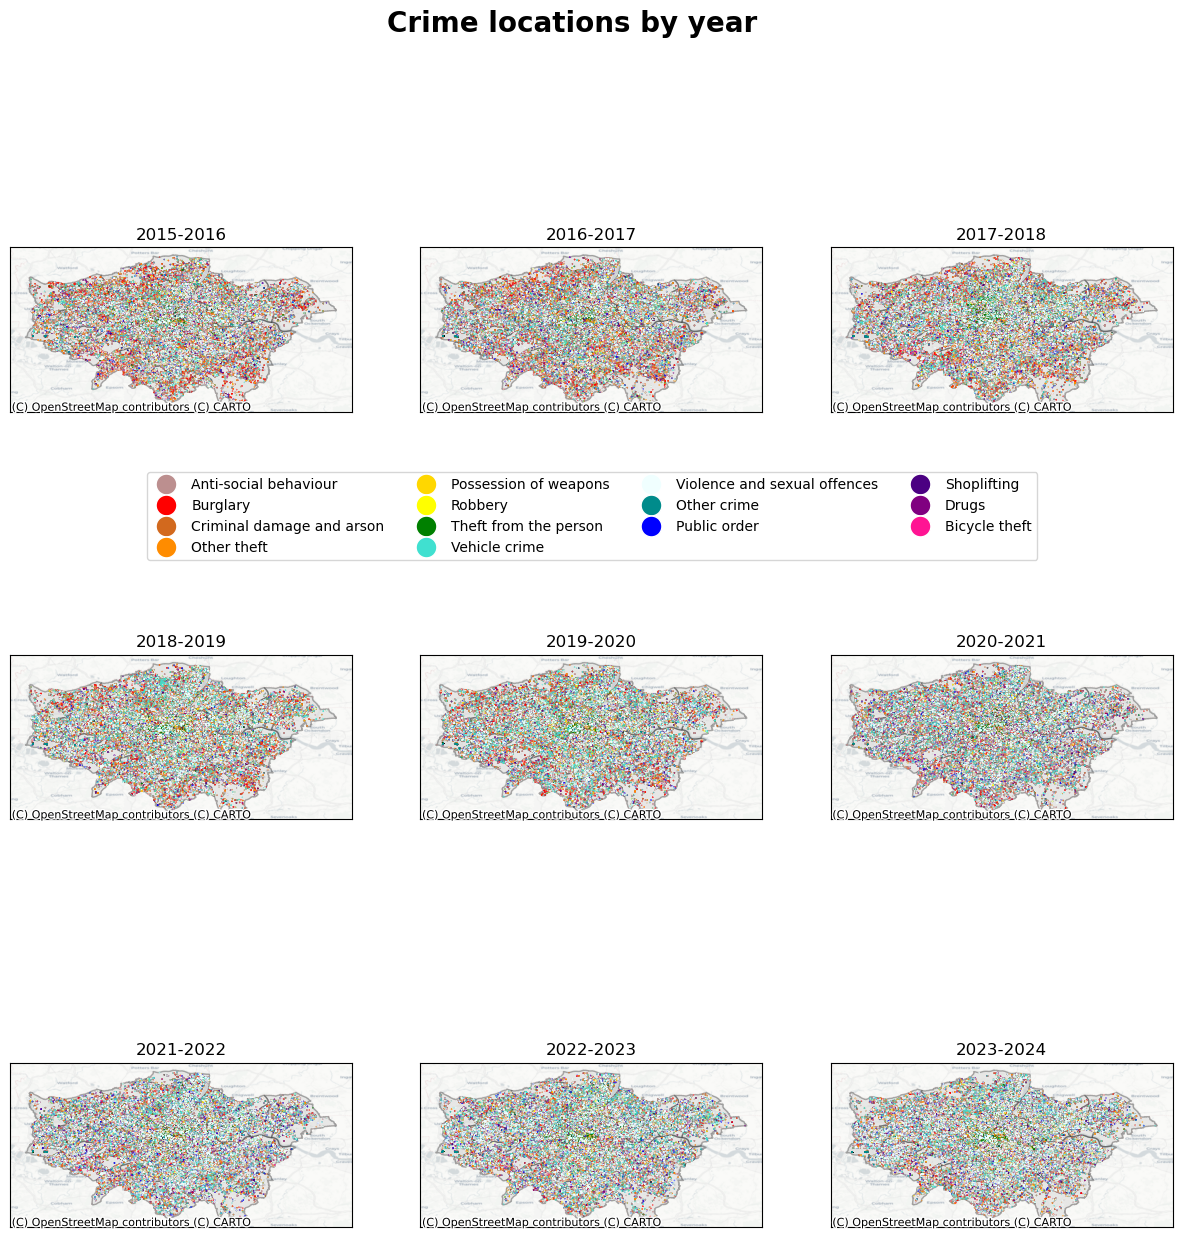

In [16]:
# plot crime incidents over map of london with crime type specified
import matplotlib.pyplot as plt
import contextily as cx

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(15,15))
axes = axes.flatten()

for i in range(9):
    london_map.plot(
        ax=axes[i], 
        alpha=0.3, 
        edgecolor='black', 
        facecolor='silver',)
    axes[i].set_title(f'{years[i]}')
    axes[i].xaxis.set_tick_params(labelbottom=False)
    axes[i].yaxis.set_tick_params(labelleft=False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    time_range[i].plot(ax=axes[i], alpha= 0.5, marker='*', c= time_colors[i].map(category_colors), markersize=.01)
    cx.add_basemap(axes[i],source=cx.providers.CartoDB.Positron, crs=london_map.crs)
    
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor= (-2, 4.6), ncol=4,
            borderaxespad=0)
plt.suptitle('Crime locations by year', fontsize=20, weight='bold')

plt.show()

<div style='text-align: justify;'>The series of maps displayed above illustrates the geographic distribution of various crime incidents across London over consecutive annual periods from 2015 to 2024. Each map corresponds to a different year, with distinct colors marking the locations of diverse crime types, such as anti-social behavior, burglary, and vehicle crime. Notably, the plots reveal the spread and concentration of incidents, potentially indicating areas with higher crime rates or shifts in crime patterns over time. This visualization effectively demonstrates the spatial distribution of crime over different years and provides insights into the patterns and density of crime occurrences in London.<div>

### Choropleth maps: Average monthly crime rate by year

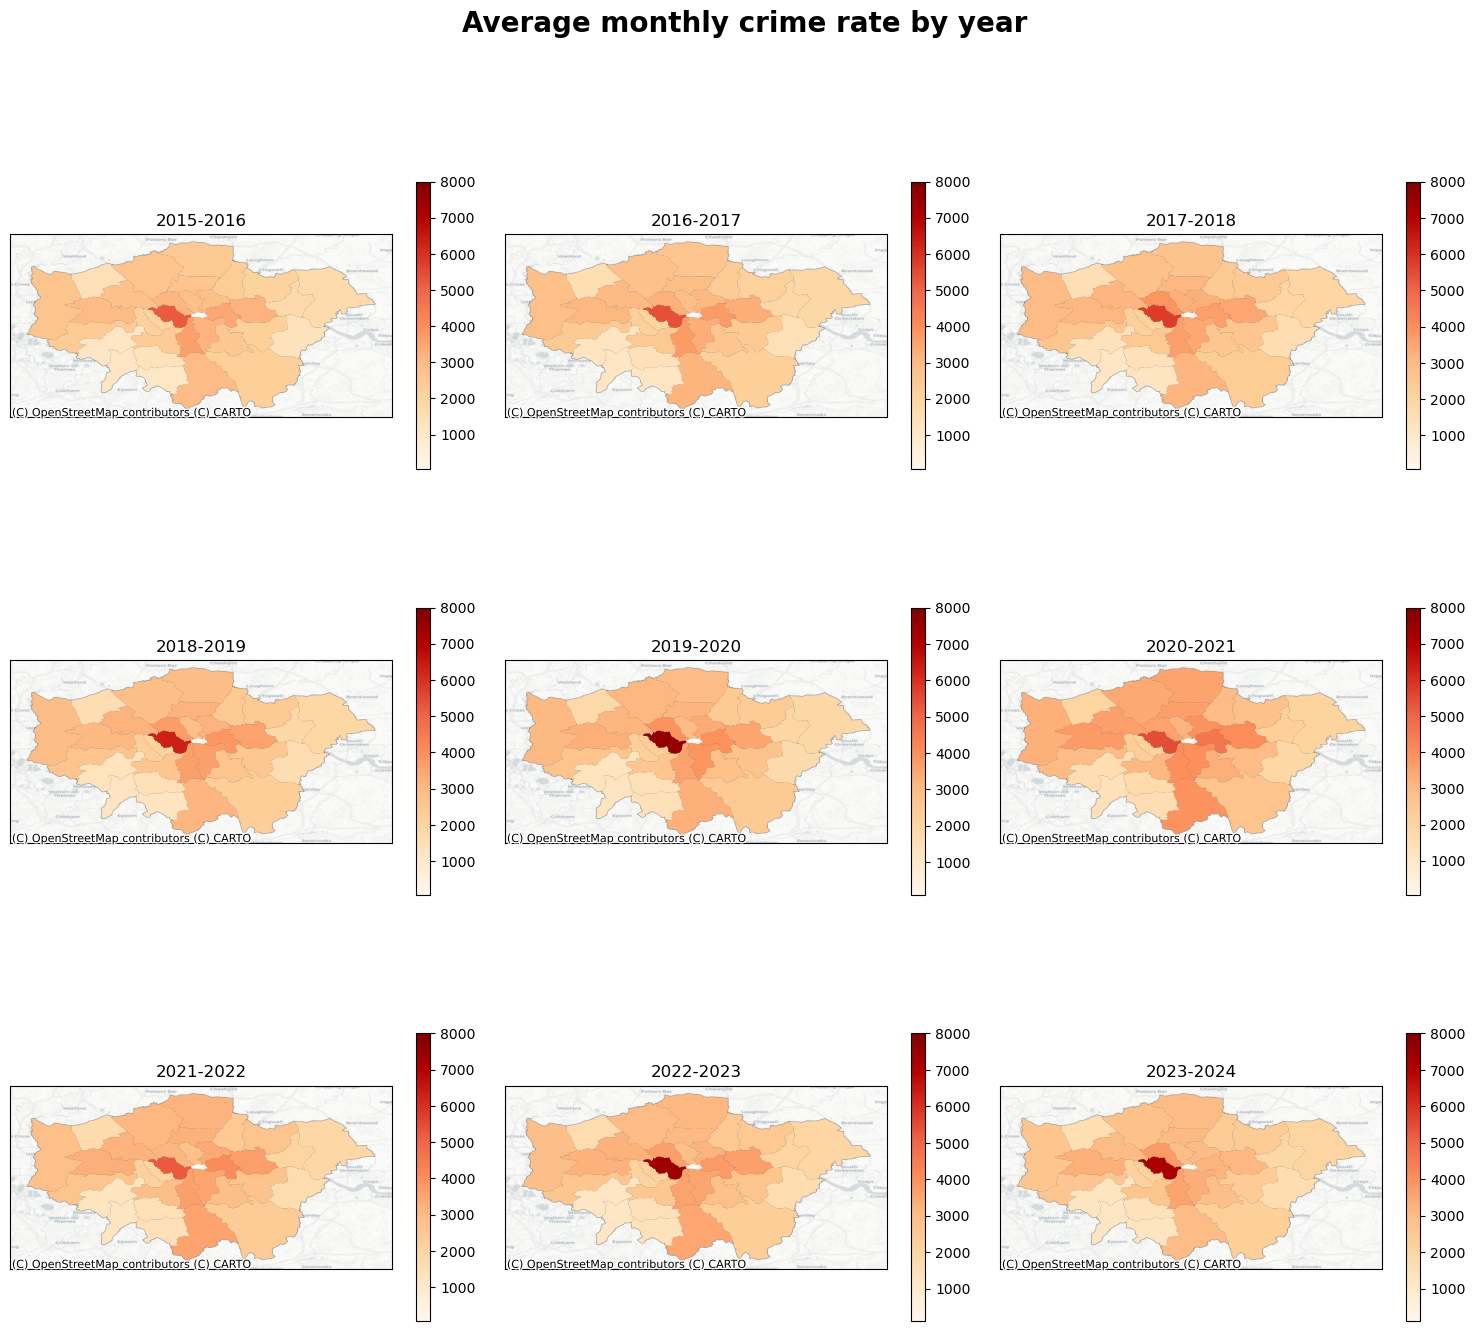

In [17]:
# plot heatmap of crime by borough

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(15,15))
axes = axes.flatten()
for i in range(9):
    london_map.plot(
        ax=axes[i], 
        alpha=0.3, 
        edgecolor='black', 
        facecolor='silver',)
    axes[i].set_title(f'{years[i]}')
    axes[i].xaxis.set_tick_params(labelbottom=False)
    axes[i].yaxis.set_tick_params(labelleft=False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
    borough_crime_counts = time_range[i].groupby('LSOA name').size().reset_index(name='counts')
    london_crime_map = london_map.merge(borough_crime_counts, left_on = 'NAME', right_on = 'LSOA name')
    
    # calculate monthly average as 2023 data isn't complete
    if i == 8:
        london_crime_map['counts'] = london_crime_map['counts'].div(10)
    else:
        london_crime_map['counts'] = london_crime_map['counts'].div(12)
    london_crime_map.plot(ax=axes[i], column='counts', cmap='OrRd', legend=True, markersize=.1, vmax=8000, legend_kwds={'shrink':0.5}) 
    cx.add_basemap(axes[i],source=cx.providers.CartoDB.Positron, crs=london_map.crs)
plt.suptitle('Average monthly crime rate by year', fontsize=20, weight='bold')
fig.tight_layout()
plt.show()



<div style='text-align: justify;'>The sequence of choropleth maps presented above visualize the average monthly crime rates across the boroughs of London from 2015-2016 to 2023-2024. Each borough's color intensity corresponds to its crime frequency, as indicated by the color gradient on the legend to the right. The maps reveal patterns and trends in crime occurrence, with certain boroughs consistently showing higher crime rates over the years. The darkest area suggests the highest concentration of crime, highlighting the borough with the most significant number of reported incidents, which in the above given map is <b>Westminster</b>. This visualization is the result of aggregating crime data by 'LSOA name', merging it with a geographical map of London. The map effectively communicates geographical patterns of crime, potentially serving as a tool for identifying hotspots and informing policy or security measures.</div>

### Correlation Heatmap of Crime Types 

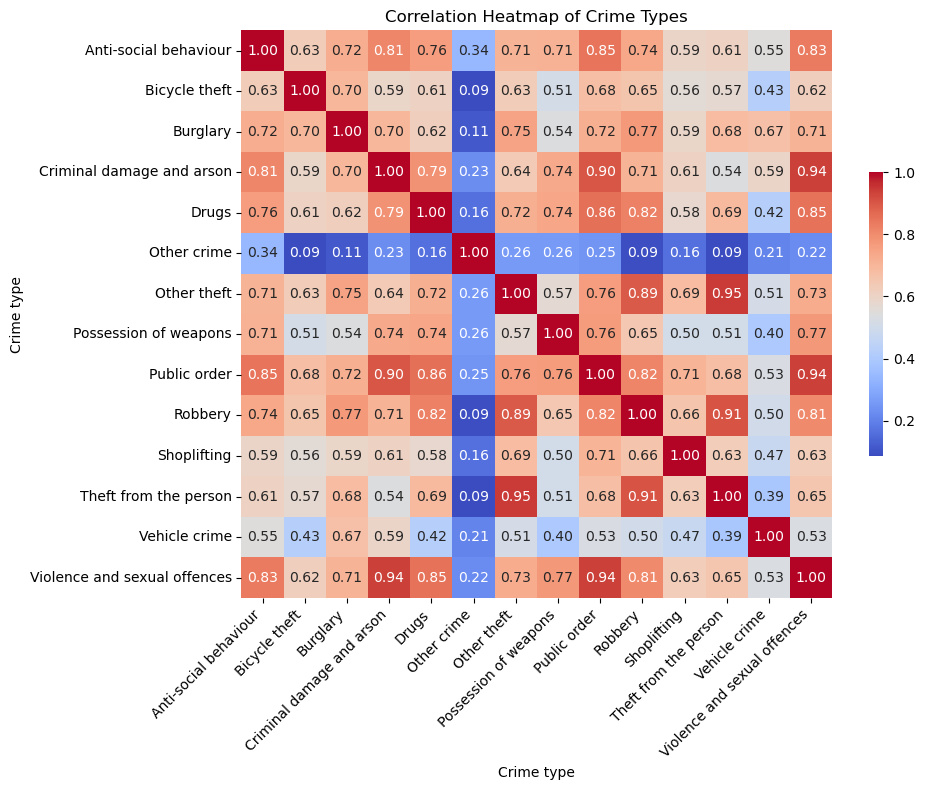

In [18]:
# Pivot the data to get the count of each crime type for each LSOA code
crime_type_counts = df_crime_london_na.pivot_table(index='LSOA code', columns='Crime type', aggfunc='size', fill_value=0)
# Calculate the correlation matrix
correlation_matrix = crime_type_counts.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap of Crime Types')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()  
# Show the plot
plt.show()

<div style='text-align: justify;'>The heatmap provided is a visual representation of the correlation between various crime types within different regions, delineated by the LSOA codes. It uses a color spectrum from blue (indicating negative or weaker correlations) to red (indicating positive or stronger correlations) to reflect the Pearson correlation coefficients. <b>Crimes that are closely related, such as anti-social behavior and public order offenses, show strong positive correlations</b>, suggesting they often occur together or are influenced by similar factors. The layout of the heatmap, with clearly annotated correlation values and color intensities, allows for quick assessment of these relationships.</div>

### Pie Chart: Distribution of different crimes (Pre-COVID, During COVID and Post-COVID) 

In [19]:
# Covid start and end time period
pre_covid_end_date = pd.to_datetime('2020-03-01')
post_covid_start_date = pd.to_datetime('2021-12-01')

# Filetring the data for each period
pre_covid_data = df_crime_london_na[df_crime_london_na['Month'] < pre_covid_end_date]
covid_period_data = df_crime_london_na[
    (df_crime_london_na['Month'] >= pre_covid_end_date) &
    (df_crime_london_na['Month'] < post_covid_start_date)
]
post_covid_data = df_crime_london_na[df_crime_london_na['Month'] >= post_covid_start_date]


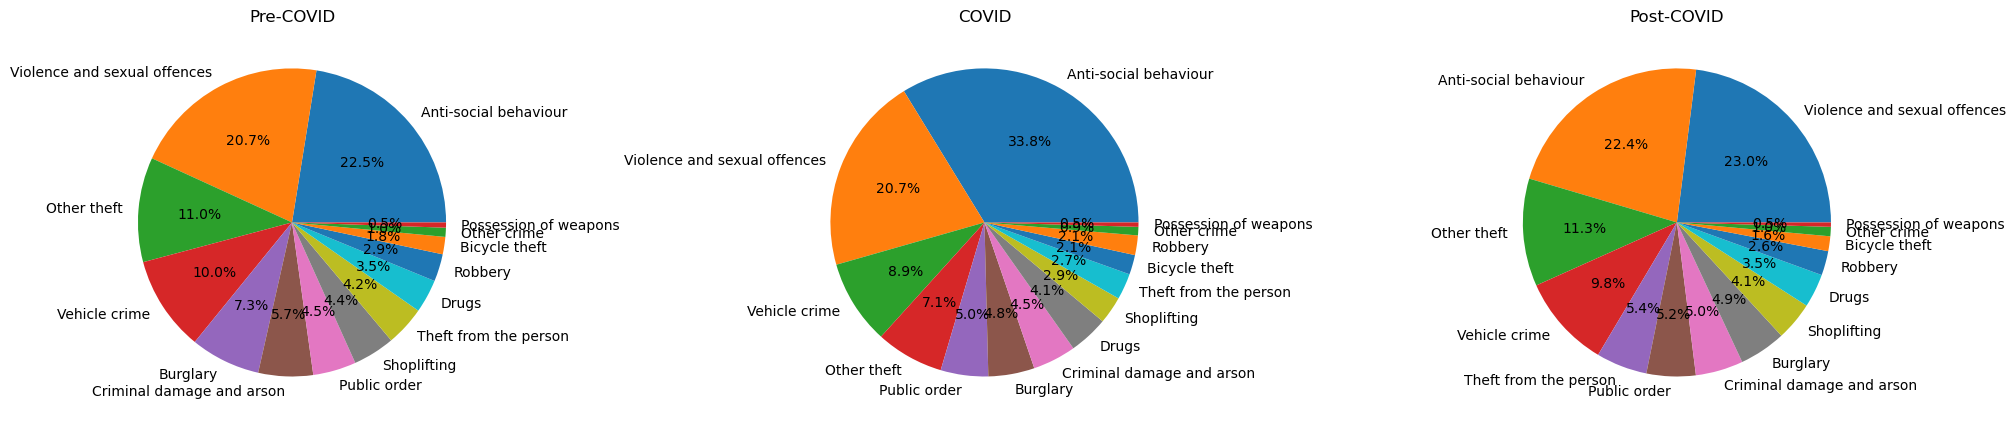

In [20]:
# plotting
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot Pre-COVID pie chart
pre_covid_data['Crime type'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', ax=axes[0], title='Pre-COVID', legend=False
)
axes[0].set_ylabel('')  # Hide the y-label

# Plot COVID pie chart
covid_period_data['Crime type'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', ax=axes[1], title='COVID', legend=False
)

axes[1].set_ylabel('')  # Hide the y-label

# Plot Post-COVID pie chart
post_covid_data['Crime type'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', ax=axes[2], title='Post-COVID', legend=False
)

axes[2].set_ylabel('')  # Hide the y-label

# Layout
plt.tight_layout()
plt.show()


<div style='text-align: justify;'>
Prior to COVID, '<b>Violence and sexual offences</b>' and '<b>Anti-social behaviour</b>' were the most significant portions of the crime distribution, making up roughly 20.7% and 22.5%, respectively. During the COVID period, there was a noticeable increase in '<b>Public order</b>' crimes, suggesting a rise in incidents that disturbed the peace or violated the rules of lockdowns and other restrictions. '<b>Shoplifting</b>' saw a significant decrease, which could be attributed to the closure of retail stores and the reduction in opportunities for this type of crime during lockdowns. '<b>Anti-social behaviour</b>' became the dominant crime type, constituting over a third of all crimes, potentially due to the heightened tensions and societal stress during lockdowns. In the Post-COVID period, '<b>Violence and sexual offences</b>' slightly increased to become the largest share of crimes, alongside a decrease in '<b>Anti-social behaviour</b>'. '<b>Public order</b>' crimes reduced compared to the COVID period, indicating a potential return to pre-pandemic levels. '<b>Shoplifting</b>' did not rebound to its pre-pandemic proportions, which might suggest a continued impact of the pandemic on retail crime or changes in consumer behavior.
</div>


### Overall Crime Rate in London  

<Figure size 1500x600 with 0 Axes>

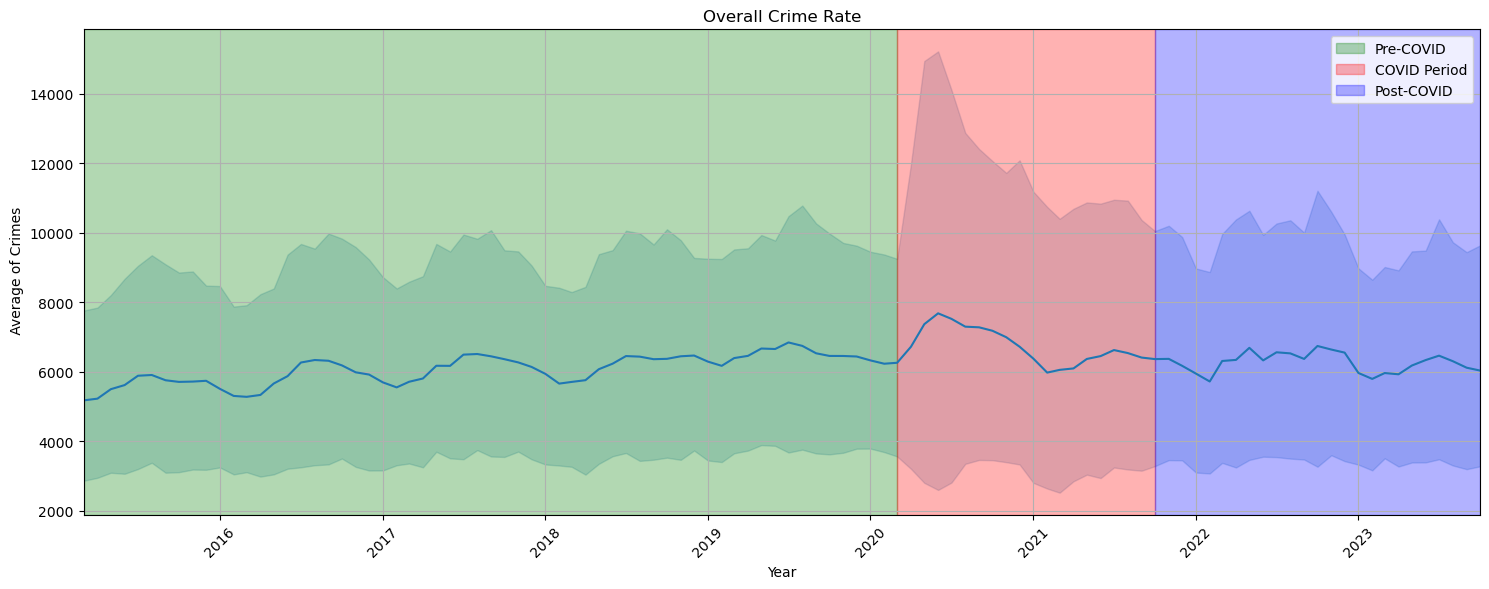

In [21]:
rolling_avg = df_crime_london_na.groupby('Month')['Crime type'].value_counts().unstack().rolling(window=3).mean().stack().reset_index(name='rolling_avg')
rolling_avg['Month'] = pd.to_datetime(rolling_avg['Month'])
plt.figure(figsize=(15, 6))

import matplotlib.dates as mdates

pre_covid_end = '2020-03-01'  # The date when COVID-19 was declared a pandemic or when lockdown started
post_covid_start = '2021-10-01'  # The date when lockdown measures were significantly lifted

# Convert dates to datetime
pre_covid_end = pd.to_datetime(pre_covid_end)
post_covid_start = pd.to_datetime(post_covid_start)

plt.figure(figsize=(15, 6))

# Plot the data
sns.lineplot(data=rolling_avg, x='Month', y='rolling_avg')

# Highlight different periods
plt.axvspan(rolling_avg['Month'].min(), pre_covid_end, color='green', alpha=0.3, label='Pre-COVID')
plt.axvspan(pre_covid_end, post_covid_start, color='red', alpha=0.3, label='COVID Period')
plt.axvspan(post_covid_start, rolling_avg['Month'].max(), color='blue', alpha=0.3, label='Post-COVID')

# Formatting the x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Setting the x-axis limits
plt.xlim(rolling_avg['Month'].min(), rolling_avg['Month'].max())

# Setting the plot title and labels
plt.title('Overall Crime Rate')
plt.xlabel('Year')
plt.ylabel(' Average of Crimes')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



<div style='text-align: justify;'>
In the above visualization, we look into the <b>trends of the overall crime rate in London</b>, with a particular focus on the temporal shifts in relation to the <b>COVID-19 pandemic</b>. The analysis is divided into three distinct phases to offer a clearer perspective on the pandemic's impact:</div>

<div style='text-align: justify;'><b>Pre-COVID Period</b>: This phase covers the time before the COVID-19 pandemic reached the UK and lockdown measures were implemented. It serves as a baseline for our analysis, allowing us to understand the normal fluctuation of crime rates prior to the extraordinary circumstances brought about by the pandemic. Prior to the pandemic, the crime rates show some fluctuation but maintain a relatively steady pattern. This suggests a level of consistency in crime rates before the disruption caused by the pandemic.</div>

<div style='text-align: justify;'><b>COVID Period</b>: This is the period during which London was directly affected by the pandemic and subjected to varying levels of restrictions. After an initial spike, it appears that the crime rate initially decreased quite significantly when the lockdowns were first imposed. This reduction in crime could be attributed to the restrictions on movement, which limited opportunities for certain types of crime.</div>

<div style='text-align: justify;'><b>Post-COVID Period</b>: This phase represents the time after the initial lockdowns were lifted and as the new normal began, the crime rates started to fluctuate again, but they did not immediately return to pre-COVID levels. Instead, we see a period of instability, with crime rates going below the earlier baseline at some points and exceeding it at others. This could be indicative of the societal and economic impacts of the pandemic, which might have led to changes in crime patterns.</div>

<div style='text-align: justify;'>To smooth out short-term fluctuations and reveal underlying trends, we have applied a <b>3-month rolling average</b> to the crime rate data. This statistical technique averages out the data over three-month windows, providing a clearer view of the progression of crime rates through these distinct periods.
</div>


### London Crime Heatmap 

In [22]:
import pandas as pd
import plotly.express as px
from datetime import datetime

# Extract the year from the index (since 'Month' is now the index)
df_crime_london_na['Year'] = pd.to_datetime(df_crime_london_na['Month']).dt.year

# Get the most recent year
most_recent_year = df_crime_london_na['Year'].max()

# Filter the DataFrame for the most recent year
recent_year_data = df_crime_london_na[df_crime_london_na['Year'] == most_recent_year]

# Sample the data 
crime_data_sample = recent_year_data.sample(n=10000, random_state=1) #sample heatmap that will serve as a demonstration of how the full dataset could be visualized

# Setting a constant size for markers
crime_data_sample['size'] = 4

# Get unique crime types
crime_types = crime_data_sample['Crime type'].unique()

# Preparing a dictionary to hold data for each crime type
plot_dfs = {}

# Loop through crime types and prepare data for plotting
for crime_type in crime_types:
    # Filter data for the current crime type
    crime_type_df = crime_data_sample[crime_data_sample['Crime type'] == crime_type]
    # Save data for plotting
    plot_dfs[crime_type] = crime_type_df


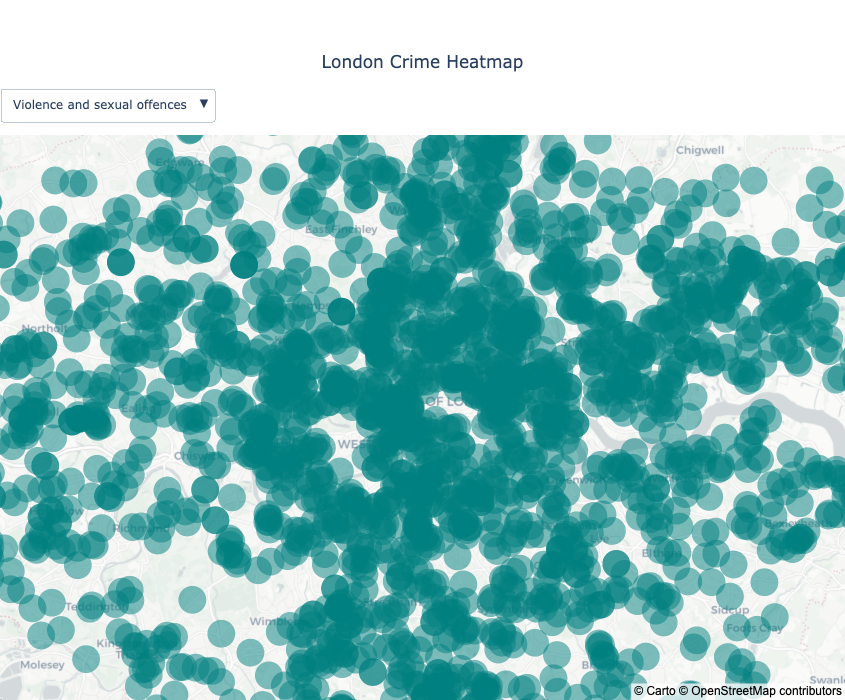

In [23]:
# Create the initial map scatter plot
initial_crime_type = crime_types[0] if len(crime_types) > 0 else ""
initial_plot_data = plot_dfs[initial_crime_type] if initial_crime_type else pd.DataFrame()

fig2 = px.scatter_mapbox(
    initial_plot_data, 
    title='London Crime Heatmap', 
    lat="Latitude", lon="Longitude",
    color_discrete_sequence=['TEAL'], zoom=10,
    size='size',
    mapbox_style='carto-positron', 
    opacity=0.5, height=700
)

# Create dropdown buttons for each crime type
buttons = []

for crime_type in crime_types:
    # Select crime type data
    data = plot_dfs[crime_type]
    # Define button arguments
    args = [{'lat': [data['Latitude']], 'lon': [data['Longitude']], 'marker.size': [data['size']]}]
    # Create button
    button = dict(args=args, label=crime_type, method='restyle')
    buttons.append(button)

# Add dropdown to the figure
fig2.update_layout(
    updatemenus=[
        dict(
            buttons=list(buttons),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
    ]
)

# Set the default crime type in the dropdown
current_button = list(crime_types).index(initial_crime_type) if initial_crime_type else -1
fig2.layout.updatemenus[0]['active'] = current_button

# Update layout
fig2.update_layout(margin={"r":0,"t":135,"l":0,"b":0}, title_x=0.5)

# Display the figure
fig2.show()


<div style='text-align: justify;'>An intricate visual representation of crime events in London can be seen in the interactive crime heatmap made with Plotly. It excels in terms of user interaction, allowing users to navigate through different categories of crimes using dropdown menus, and clearly displaying the geographic distribution of crimes in the last year using scatter mapbox plots to get a better picture of the extent of these crimes in recent times. However, its focus on granular detail results in a less intuitive interface, making it challenging for quick, high-level interpretation. Additionally, while the map's sensitivity to zoom levels and its color scheme effectively indicate crime density, it struggles to differentiate areas with very high crime rates. Thus, while the heatmap is a powerful tool for detailed exploration, its complexity might limit its usability for seeking straightforward, immediate insights into crime patterns.</div>

### 3-Month Rolling Average of Reported Crime by Type (per 100,000) 

<div style='text-align: justify;'>
In the following analysis, we have <b>normalized the crime data to reflect rates per 100,000 individuals</b>, enabling a comparative view that accounts for changes in population over time. This method allows for a more accurate assessment of crime trends, unaffected by the natural growth or decline in the number of residents. The plot showcases the <b>3-month rolling average of reported crimes by type</b>, providing an insight into how different categories of crime have trended throughout the pandemic. Significant events, such as <b>lockdowns</b> and <b>reopening phases</b>, are marked with vertical lines. <b>Black dashed lines</b> indicate the onset of lockdown periods, moments when stringent measures were implemented, while <b>grey dashed lines</b> signify the easing of restrictions, representing steps towards normalization. Through this visualization, we aim to identify correlations between the enforcement of lockdown measures, the easing of restrictions, and fluctuations in various crime rates. The overlay of lockdown and opening dates with crime trends offers a narrative on how the pandemic's phases may have influenced criminal behavior in London.
</div>


In [24]:
# yearly estimated population extracted from https://apps.london.gov.uk/population-projections/

pop15 = 8666928.00
pop16 = 8769659.00
pop17 = 8824999.00
pop18 = 8908083.00
pop19 = 8961990.00
pop20 = 9002488.00
pop21 = 8915981.00
pop22 = 9002488.00
pop23 = 9083272.00

In [25]:
# calculate 3-month rolling average of crime by type

crime_rolling_avg = df_crime_london_na.groupby('Month')['Crime type'].value_counts().unstack().rolling(window=3).mean().stack().reset_index(name='rolling_avg')

In [26]:
# add population estimates to df

crime_rolling_avg.loc[crime_rolling_avg['Month'] <= '2015-12-31', 'Population'] = pop15
crime_rolling_avg.loc[crime_rolling_avg['Month'] <= '2016-12-31', 'Population'] = pop16
crime_rolling_avg.loc[crime_rolling_avg['Month'] <= '2017-12-31', 'Population'] = pop17
crime_rolling_avg.loc[crime_rolling_avg['Month'] <= '2018-12-31', 'Population'] = pop18
crime_rolling_avg.loc[crime_rolling_avg['Month'] <= '2019-12-31', 'Population'] = pop19
crime_rolling_avg.loc[crime_rolling_avg['Month'] <= '2020-12-31', 'Population'] = pop20
crime_rolling_avg.loc[crime_rolling_avg['Month'] <= '2021-12-31', 'Population'] = pop21
crime_rolling_avg.loc[crime_rolling_avg['Month'] <= '2022-12-31', 'Population'] = pop22
crime_rolling_avg.loc[crime_rolling_avg['Month'] <= '2023-12-31', 'Population'] = pop23

In [27]:
# calculate crimes per 100,000 people

crime_rolling_avg['Crimes per 100,000'] = (crime_rolling_avg['rolling_avg'] / crime_rolling_avg['Population']) * 100000

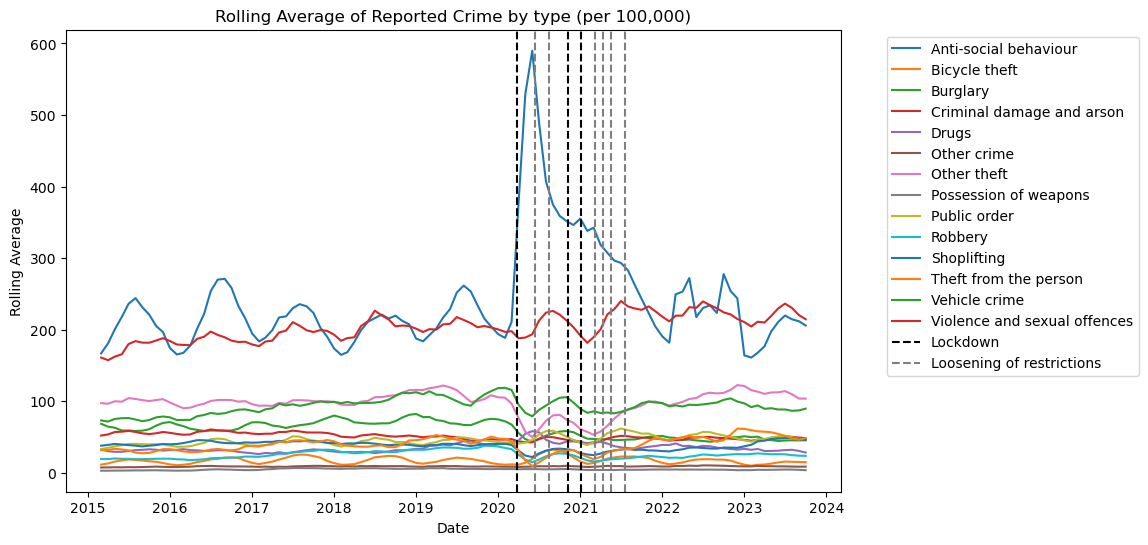

In [28]:
# plot rolling average of crime by type
# key points in governmental responses to COVID are marked by vertical lines

plt.figure(figsize=(10, 6))
lockdown1 = pd.to_datetime('2020-03-26',
               format='%Y-%m-%d')

lockdown2 = pd.to_datetime('2020-11-05',
               format='%Y-%m-%d')


lockdown3 = pd.to_datetime('2021-01-06',
               format='%Y-%m-%d')


opening1 = pd.to_datetime('2020-06-14',
               format='%Y-%m-%d')

opening2 = pd.to_datetime('2020-08-14',
               format='%Y-%m-%d')

opening3 = pd.to_datetime('2021-03-08',
               format='%Y-%m-%d')

opening4 = pd.to_datetime('2021-04-12',
               format='%Y-%m-%d')

opening5 = pd.to_datetime('2021-05-17',
               format='%Y-%m-%d')

opening6 = pd.to_datetime('2021-07-19',
               format='%Y-%m-%d')

for category in crime_rolling_avg['Crime type'].unique():
    plt.plot(crime_rolling_avg[crime_rolling_avg['Crime type'] == category]['Month'],
             crime_rolling_avg[crime_rolling_avg['Crime type'] == category]['Crimes per 100,000'],
             label=category)

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
lockdown1 = plt.axvline(x=lockdown1, color="black", linestyle="dashed")
plt.axvline(x=lockdown2, color="black", linestyle="dashed")
plt.axvline(x=lockdown3, color="black", linestyle="dashed")
opening1 = plt.axvline(x=opening1, color="grey", linestyle="dashed")
plt.axvline(x=opening2, color="grey", linestyle="dashed")
plt.axvline(x=opening3, color="grey", linestyle="dashed")
plt.axvline(x=opening4, color="grey", linestyle="dashed")
plt.axvline(x=opening5, color="grey", linestyle="dashed")
plt.axvline(x=opening6, color="grey", linestyle="dashed")
plt.title('Rolling Average of Reported Crime by type (per 100,000)')
plt.xlabel('Date')
plt.ylabel('Rolling Average')
legend = plt.legend(loc='best')


existing_handles  = legend.legend_handles
existing_labels = [x.get_text() for x in legend.get_texts()]
existing_handles.append(lockdown1)
existing_labels.append('Lockdown')

existing_handles.append(opening1)
existing_labels.append('Loosening of restrictions')

plt.legend(existing_handles, existing_labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

<div style='text-align: justify;'>
<b>Overall Trend</b>: Each color represents a different type of crime, and each line shows how the rolling average of reports for that crime type has changed over time. The plot covers several years, giving a long-term view of crime trends.
</div>

<div style='text-align: justify;'>
<b>Spikes After Lockdowns</b>: The dotted black lines represent the time when lockdowns were implemented. After each of these lines, there is a noticeable spike in certain types of crime, particularly <b>anti-social behavior</b> and <b>violence & sexual offenses</b>. This could indicate a pattern where such crimes see an increase following the initial shock or the lifting of lockdowns.
</div>

<div style='text-align: justify;'>
<b>Behavior During Lockdowns</b>: During the lockdown periods, there seems to be a general decrease in most crime types, which aligns with expectations since lockdowns typically reduce opportunities for certain crimes due to restrictions on movement and the closure of public spaces.
</div>

<div style='text-align: justify;'>
<b>Specific Crime Types</b>: The most pronounced spikes are seen in <b>anti-social behavior</b>, which could be a response to the lifting of restrictions, as people start to go out more and potentially engage in conflict. Similarly, <b>violence and sexual offenses</b> also show spikes, which may reflect a release of tensions that could build up during periods of confinement.
</div>

<div style='text-align: justify;'>
<b>Post-Lockdown Patterns</b>: After the final lockdown line, we see an overall upward trend in most crime types. This could be due to a return to normal activity levels, or it could be indicative of longer-term social and economic impacts of the pandemic.
</div>


### Augmented Dickey-Fuller test

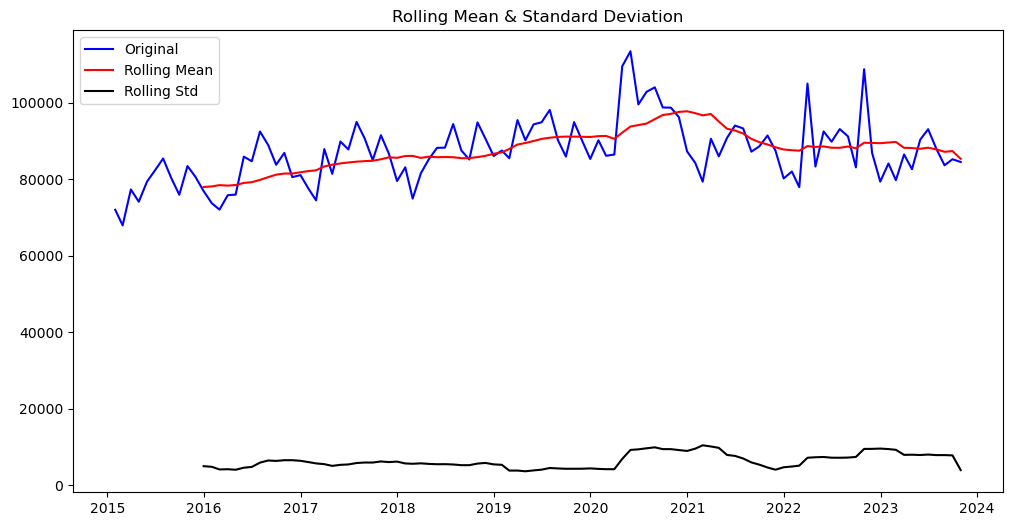

Results of Dickey-Fuller Test:


Test Statistic                 -1.906063
p-value                         0.329214
#Lags Used                     12.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64

In [29]:
#Statstical test
# Convert 'Month' to datetime and aggregate data
df_crime_london_na['Month'] = to_datetime(df_crime_london_na['Month']) + MonthEnd(0)  # Adjust to end of month
monthly_crime_counts = df_crime_london_na.groupby('Month').size()

# Function to perform Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

# Test stationarity of the monthly crime counts
test_stationarity_results = test_stationarity(monthly_crime_counts)
test_stationarity_results

<div style='text-align: justify;'>
The plot shows variations in the <b>rolling mean and standard deviation</b> over time, suggesting that the series may not be stationary. The <b>Dickey-Fuller test</b> results suggest that the crime rate data is likely non-stationary, as indicated by a <b>Test Statistic (-1.906063)</b> higher than critical values and a high <b>p-value (0.329214)</b>, implying the non-rejection of the null hypothesis of a unit root presence. This non-stationarity could be influenced by the societal impacts of COVID-19, evident from fluctuations in the rolling mean and standard deviation.
</div>

<div style='text-align: justify;'>
These fluctuations during the pandemic might reflect changes in criminal activities due to factors like <b>lockdowns, policing changes, and shifts in public behavior</b>. The test underscores the potential impact of the pandemic on crime rates, suggesting that the extraordinary circumstances during this period significantly affected crime patterns.
</div>


## Data Modelling 

### ARIMA Model 

In [30]:
# Convert the 'Month' column to datetime
df_crime_london_na['Month'] = pd.to_datetime(df_crime_london_na['Month'])

# Define your period start and end dates
pre_covid_end_date = pd.to_datetime('2020-03-01')
post_covid_start_date = pd.to_datetime('2021-12-01')

# Filter the data for each period
pre_covid_data = df_crime_london_na[df_crime_london_na['Month'] < pre_covid_end_date]
covid_period_data = df_crime_london_na[
    (df_crime_london_na['Month'] >= pre_covid_end_date) &
    (df_crime_london_na['Month'] < post_covid_start_date)
]
post_covid_data = df_crime_london_na[df_crime_london_na['Month'] >= post_covid_start_date]

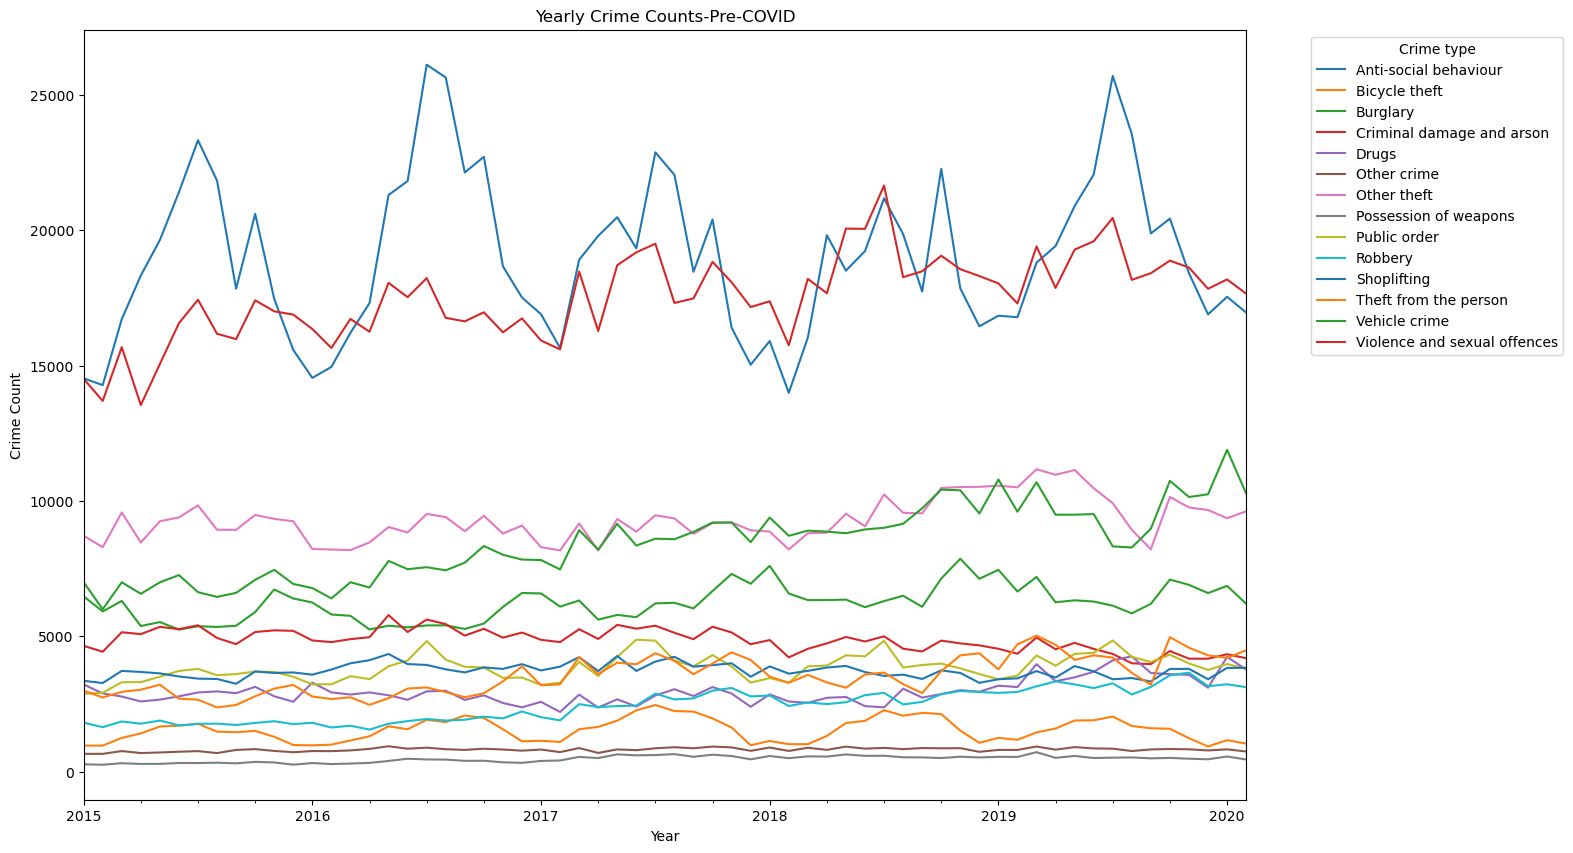

In [31]:
# Group and count crimes by type and month for pre-COVID data
monthly_pre_covid_counts = pre_covid_data.groupby(['Crime type', pd.Grouper(key='Month', freq='M')]).size().unstack(fill_value=0)
# Vizualizing the crime counts
monthly_pre_covid_counts.transpose().plot(figsize=(15, 10), title='Yearly Crime Counts-Pre-COVID')
plt.legend(title='Crime type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Year')
plt.ylabel('Crime Count')
plt.show()

<div style='text-align: justify;'>
Focusing on the <b>pre-COVID segment</b>, the plot aggregates the monthly crime counts by type, creating a line chart that delineates crime trends leading up to March 2020. Each crime type is represented by a distinct line, revealing any <b>seasonal variations</b> or consistent patterns that occurred before the pandemic's onset. This visualization serves as a <b>baseline</b> to understand the normal fluctuations in crime rates, which is essential for evaluating the pandemic's impact on crime dynamics.
</div>


In [32]:
# Fit ARIMA models for each crime type ((p,q,d )=(1,1,1))
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
df_crime_london_na.set_index('Month', inplace=True)

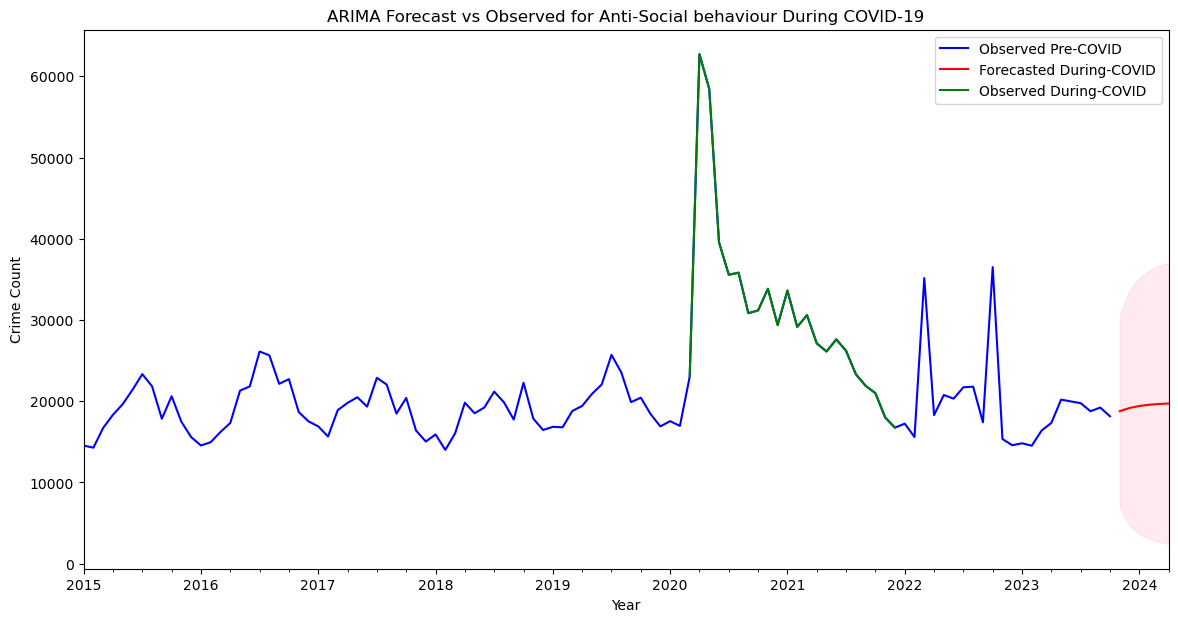

In [33]:

pre_covid_crime_counts = df_crime_london_na[df_crime_london_na['Crime type'] == 'Anti-social behaviour'].resample('M').size()
# Fit the ARIMA model on the pre-COVID data.
arima_model = ARIMA(pre_covid_crime_counts, order=(1, 1, 1))
arima_result = arima_model.fit()
forecast = arima_result.get_forecast(steps=6)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()
# Plotting the observed pre-COVID data, the forecasted data, and the actual observed data during COVID.
plt.figure(figsize=(14, 7))
# Plotting the observed pre-COVID data
pre_covid_crime_counts.plot(label='Observed Pre-COVID', color='blue')
# Plot forecasted data with confidence intervals
forecast_mean.plot(label='Forecasted During-COVID', color='red')
plt.fill_between(forecast_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
# Plot the actual observed data during COVID
start_covid_period = '2020-03-01'
end_covid_period = '2021-12-31'
actual_covid_data = df_crime_london_na[(df_crime_london_na.index >= start_covid_period) & 
                                 (df_crime_london_na.index <= end_covid_period) & 
                                 (df_crime_london_na['Crime type'] == 'Anti-social behaviour')].resample('M').size()
actual_covid_data.plot(label='Observed During-COVID', color='green')
plt.title('ARIMA Forecast vs Observed for Anti-Social behaviour During COVID-19')
plt.xlabel('Year')
plt.ylabel('Crime Count')
plt.legend()
plt.show()


<div style='text-align: justify;'>
In our study, we implement an <b>ARIMA model</b> to evaluate the trends and forecast the incidence of <b>anti-social behavior</b> in London, contextualized by the COVID-19 pandemic. The graph presents a comparison of observed and forecasted anti-social behavior crime counts before and during the COVID-19 pandemic. The observed <b>pre-COVID data</b> (blue line) shows the crime count up to the onset of the pandemic, while the observed <b>during-COVID data</b> (green line) displays a significant decrease in crime rates, likely due to lockdown measures. The <b>forecasted data</b> (red line), based on an ARIMA model, failed to predict the pandemic's impact, overestimating crime rates during this period. The shaded area towards the end indicates future projections, which should be interpreted with caution as they do not account for unforeseen events similar to the pandemic. The graph highlights the limitations of traditional forecasting models in the face of unprecedented changes.
</div>



### Logistic Regression Model

<div style='text-align: justify;'> In order to further determine whether or not the designated periods differed in crime trends, we train a <b>logistic regression model</b> to classify incidents of crime by type. We train the model on <b>pre-COVID data</b> consisting of longitude, latitude, LSOA name, and datetimes that only consist of the month (we do not want the model learning from the year). Both LSOA name and month are treated as categorical data and are <b>onehot-encoded</b>. The classes represent the <b>14 different crime types</b> present in the dataset and are equally distributed in the training set. Model performance is then evaluated based on <b>macro-average Receiver Operating Characterics (ROC) curves</b> and their respective <b>Area Under the Curve (AUC) scores</b>, as well as <b>Precision-Recall curves</b> (with average precision scores). By training a model solely on pre-COVID data and then evaluating its performance with respect to the three distinct time periods, we aim to determine whether or not the model is equally effective at classifying criminal incidents for all three periods. If the model's performance is similar for all three periods, this would imply that the during-COVID and post-COVID data do not significantly differ from pre-COVID data.
</div>


In [34]:
# location and lsoa code can be dropped because they are captured by longitude, latitude, and LSOA name
df_ml = df_ml_full.drop(columns=['Location','LSOA code'])

# one-hot encode LSOA name since it is categorical
df_ml_onehot = pd.get_dummies(df_ml, columns=['LSOA name'])

In [35]:
pre_covid_start = '2020-03'

covid_start = '2020-03'
covid_end = '2021-08'

post_covid_start = '2021-08'

# Use the datetime index for comparison
pre_covid = df_ml_onehot[df_ml_onehot['Month'] < pre_covid_start]
covid = df_ml_onehot[(df_ml_onehot['Month'] >= covid_start) & (df_ml_onehot['Month'] < covid_end)]
post_covid = df_ml_onehot[df_ml_onehot['Month'] > post_covid_start]

In [36]:
pre_covid['Month'] = pd.DatetimeIndex(pre_covid['Month']).month
covid['Month'] = pd.DatetimeIndex(covid['Month']).month
post_covid['Month'] = pd.DatetimeIndex(post_covid['Month']).month

/var/folders/f3/bcszcnqx26bc573250h2q5w00000gn/T/ipykernel_34667/2304724071.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f3/bcszcnqx26bc573250h2q5w00000gn/T/ipykernel_34667/2304724071.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f3/bcszcnqx26bc573250h2q5w00000gn/T/ipykernel_34667/2304724071.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [37]:
# Apply one-hot encoding
pre_covid = pd.get_dummies(pre_covid, columns=['Month'], prefix='Month')
covid = pd.get_dummies(covid, columns=['Month'], prefix='Month')
post_covid = pd.get_dummies(post_covid, columns=['Month'], prefix='Month')

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, roc_auc_score, roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression

In [39]:
# separate the three covid periods into x and y for modeling

pre_x = pre_covid.loc[:, pre_covid.columns != 'Crime type']
pre_y = pre_covid['Crime type']

covid_x = covid.loc[:, covid.columns != 'Crime type']
covid_y = covid['Crime type']

post_x = post_covid.loc[:, post_covid.columns != 'Crime type']
post_y = post_covid['Crime type']

In [40]:
RANDOM_SEED = 1 # for reproducibility

X_train, X_test, y_train, y_test =train_test_split(pre_x,pre_y, test_size=0.33, random_state=RANDOM_SEED)

In [41]:
# balance sampling of training data by crime type

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
rus = RandomUnderSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train) 

In [42]:
model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
model.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=1000, random_state=1)

In [43]:
pre_y_probs = model.predict_proba(X_test)
pre_y_labs = model.predict(X_test)

In [44]:
covid_y_probs = model.predict_proba(covid_x)
covid_y_labs = model.predict(covid_x)

In [45]:
post_y_probs = model.predict_proba(post_x)
post_y_labs = model.predict(post_x)

In [46]:
# convert label predictions into binary format

label_binarizer = LabelBinarizer().fit(y_resampled)

pre_y_onehot_labs = label_binarizer.transform(pre_y_labs)
covid_y_onehot_labs = label_binarizer.transform(covid_y_labs)
post_y_onehot_labs = label_binarizer.transform(post_y_labs)

In [47]:
# code adapted from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
# calculate roc and auc for multilabel problem

def roc(onehot, probs):
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(14):
        fpr[i], tpr[i], _ = roc_curve(onehot[:, i], probs[:, i])
        # print(fpr[i], tpr[i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    
    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)
        
    for i in range(14):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation
    
        # Average it and compute AUC
    mean_tpr /= 14
    
    fpr['macro'] = fpr_grid
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
    print('##########')
    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")
    return (fpr, tpr, roc_auc)

In [48]:
pre_fpr, pre_tpr, pre_roc_auc = roc(pre_y_onehot_labs, pre_y_probs)
covid_fpr, covid_tpr, covid_roc_auc = roc(covid_y_onehot_labs, covid_y_probs)
post_fpr, post_tpr, post_roc_auc = roc(post_y_onehot_labs, post_y_probs)

##########
Macro-averaged One-vs-Rest ROC AUC score:
0.98
##########
Macro-averaged One-vs-Rest ROC AUC score:
0.98
##########
Macro-averaged One-vs-Rest ROC AUC score:
0.98


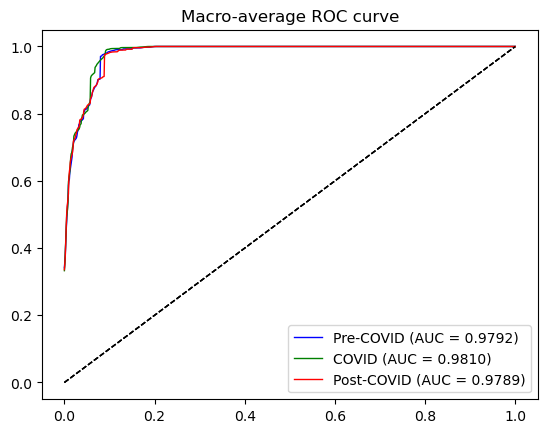

In [49]:
plt.plot(
    pre_fpr['macro'],
    pre_tpr['macro'],
    label=f"Pre-COVID (AUC = {pre_roc_auc['macro']:.4f})",
    color='blue',
    linestyle='-',
    linewidth=1,
)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')

plt.plot(
    covid_fpr['macro'],
    covid_tpr['macro'],
    label=f"COVID (AUC = {covid_roc_auc['macro']:.4f})",
    color='green',
    linestyle='-',
    linewidth=1,
)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')

plt.plot(
    post_fpr['macro'],
    post_tpr['macro'],
    label=f"Post-COVID (AUC = {post_roc_auc['macro']:.4f})",
    color='red',
    linestyle='-',
    linewidth=1,
)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.title('Macro-average ROC curve')
plt.legend()
plt.show()

<div style='text-align: justify;'>
The plot above showcases the <b>macro-average ROC curves</b> of the multilabel classification problem (14 crime types in total) for the three distinct periods labeled <b>Pre-COVID</b>, <b>COVID</b>, and <b>Post-COVID</b>. The ROC curves show the <b>True Positive Rate (TPR)</b> versus <b>False Positive Rate (FPR)</b> at all classification thresholds. The <b>AUC score</b> provides a single scalar value to gauge the effectiveness of our classification model. An AUC of 1.0 represents a perfect model, while an AUC of 0.5 suggests no discriminative power.</div>

<div style='text-align: justify;'>From the plot, it is evident that all three periods have high AUC values, suggesting that the classification model performed well across different phases of the COVID-19 pandemic. The <b>Pre-COVID</b> and <b>Post-COVID</b> periods have an AUC of <b>0.979</b>, indicating a high TPR without increasing the FPR substantially. The <b>COVID</b> period shows a slightly higher AUC of <b>0.981</b>, reflecting a potentially better model performance during this time. The dashed diagonal line represents a baseline (no skill classifier), where the TPR equals the FPR. The consistency in AUC values across different periods suggests that the locations of crimes, their types, and the time of year they occurred were not that different for the three periods.</div>


In [50]:
# code adapted from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#:~:text=Precision%2Drecall%20curves%20are%20typically,necessary%20to%20binarize%20the%20output.
# calculate precision recall curve for multilabel problem

def pr_curve(onehot, probs):
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(14):
        precision[i], recall[i], _ = precision_recall_curve(onehot[:, i], probs[:, i])
        average_precision[i] = average_precision_score(onehot[:, i], probs[:, i])
    precision['macro'], recall['macro'], _ = precision_recall_curve(onehot.ravel(), probs.ravel())
    average_precision['macro'] = average_precision_score(onehot, probs)
    return (precision, recall, average_precision)

In [51]:
pre_precision, pre_recall, pre_average_precision = pr_curve(pre_y_onehot_labs, pre_y_probs)
covid_precision, covid_recall, covid_average_precision = pr_curve(covid_y_onehot_labs, covid_y_probs)
post_precision, post_recall, post_average_precision = pr_curve(post_y_onehot_labs, post_y_probs)

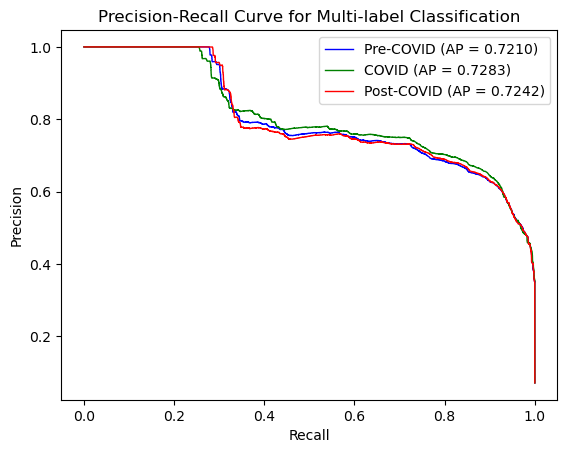

In [52]:
plt.plot(pre_recall['macro'], pre_precision['macro'], 
         label=f"Pre-COVID (AP = {pre_average_precision['macro']:.4f})", 
         color='blue',linestyle='-',linewidth=1,)
plt.plot(covid_recall['macro'], covid_precision['macro'], 
         label=f"COVID (AP = {covid_average_precision['macro']:.4f})", 
         color='green',linestyle='-',linewidth=1,)
plt.plot(post_recall['macro'], post_precision['macro'], 
         label=f"Post-COVID (AP = {post_average_precision['macro']:.4f})", 
         color='red',linestyle='-',linewidth=1,)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-label Classification')
plt.legend(loc='best')
plt.show()

<div style='text-align: justify;'>
The plot displays the <b>PR curves</b> for a multi-label classification problem, assessing model performance across three distinct periods: <b>Pre-COVID</b>, <b>COVID</b>, and <b>Post-COVID</b>. Each curve represents the trade-off between <b>precision</b> (y-axis) and <b>recall</b> (x-axis) for the respective time frames. Precision measures the proportion of true positives among the labeled instances, while recall quantifies how many actual positives were correctly identified.</div>

<div style='text-align: justify;'>The <b>Average Precision (AP) scores</b>, summarized in the legend, provide a single-figure summary of the curve, which is the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. The <b>Pre-COVID</b> period has an AP of <b>0.721</b>, indicating moderate precision and recall balance. <b>During COVID</b>, the AP is slightly higher at <b>0.728</b>, but dips again to <b>0.724</b> in the <b>Post-COVID</b> era, suggesting marginal differences in model performance across time periods.</div>

<div style='text-align: justify;'>The PR curves are relatively close together, further implying that the model's performance is consistent across different phases of the pandemic which reconfirms the argument that the locations of crimes, their types, and the time of year they occurred were not significantly different for the three periods.
</div>


## Conclusion 

<div style='text-align: justify;'>
The analysis of London's crime data from 2015-2016 to 2023-2024, utilizing several plots and statistical models, reveals significant insights into <b>crime patterns and the impact of the COVID-19 pandemic</b>. Spatial visualizations pinpoint high-crime boroughs like <b>Westminster</b> and showcase the geographical spread of various crimes, with notable shifts during the pandemic, including increases in <b>public order offenses</b> and decreases in <b>shoplifting</b>, attributed to lockdown measures and societal changes. The pandemic period highlighted the adaptability of crime to external societal pressures, with <b>anti-social behavior</b> initially surging then tapering off as restrictions eased. Statistical analyses, including <b>rolling averages and ARIMA forecasting</b>, underline the challenges in predicting crime trends, especially under the unprecedented conditions brought by the pandemic. The deviation from forecasted trends during COVID-19 underscores the limitations of traditional models in accounting for such disruptions. Machine learning evaluations through <b>ROC and PR curves</b> indicate a relatively stable performance in crime prediction across different phases of the pandemic, suggesting nuanced impacts of COVID-19 on crime rates. Overall, this comprehensive study emphasizes the dynamic nature of urban crime, influenced by both geographic factors and societal changes. The findings highlight the importance of integrating flexible analytical approaches to understand and respond to the evolving landscape of urban crime, especially in the face of global disruptions like the COVID-19 pandemic.
</div>
